# Random Search
At each iteration, we sample a random set of parameters from a zero-mean Gaussian distribution.

The best solution is kept.

# Setup

## Imports

In [1]:
import gym

Torch Modules

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
from time import time

In [4]:
from utils.environment import add_energy, make_specs, run_env

## Define Useful Functions

In [5]:
jtplot_style()

In [6]:
def get_params(model):
    parameters = torch.cat([p.data.view(-1) for p in model.parameters() if p.requires_grad])
    return parameters

In [7]:
def set_params(model, params):
    param_idx = 0
    for p in model.parameters():
        if not p.requires_grad: continue
        n_params = torch.prod(torch.IntTensor([p.size()]))
        new_param = params[param_idx: param_idx + n_params].view(p.size())
        p.data = new_param
        param_idx += n_params

In [8]:
def get_action(model, observation, probabilistic=False):
    observation = Variable(torch.from_numpy(observation).float())
    actions = model(observation.unsqueeze(0))[0]
    
    if probabilistic:
        actions = F.softmax(actions, dim=0).data.numpy()
        action = np.random.choice(np.arange(env.spec.n_act), p=actions)
    else:
        action = actions.data.numpy().argmax()
    
    return action

## Load Environment

In [9]:
env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [10]:
make_specs(env)
n_obs = env.spec.n_obs
n_act = env.spec.n_act

In [11]:
add_energy(env)

# Create Model

In [12]:
model = nn.Linear(n_obs, n_act)

# Create Searcher

In [13]:
class Searcher:
    def __init__(self, model, evaluator):
        self._model = model
        self._evaluator = evaluator
        
        self._params = get_params(model)
        self._rewards = [(0, evaluator(model))]
        self._steps = 0
        
    def __call__(self, timeout=60):
        start_time = time()
        while True:
            new_params = self._new_params()
            
            set_params(self._model, new_params)
            reward = self._evaluator(self._model)
            
            if reward > self._rewards[-1][1]:
                self._steps += 1
                self._rewards.append((self._steps, reward))
                self._params = new_params
                print(f'{reward:.2f}', end='\r')
                self._successful()
            else:
                self._unsuccessful()
                
            if time() - start_time > timeout: self.finish(); break
    
    def _new_params(self):
        pass
    
    def _successful(self):
        self._steps += 1
    
    def _unsuccessful(self):
        self._steps += 1
    
    def finish(self):
        set_params(self._model, self._params)
        
    def plot_search(self):
        plot(*zip(*self._rewards))

In [14]:
class RandomSearcher(Searcher):
    def __init__(self, model, evaluator, std=1):
        super().__init__(model, evaluator)
        self._std = std
    
    def _new_params(self):
        return torch.randn(len(self._params)) * self._std

In [15]:
def evaluator(model, gamma=0, episodes=1):
    rewards, energies = run_env(env, lambda x: get_action(model, x, probabilistic=False),
                                episodes)
    return rewards - gamma * energies

In [16]:
searcher = RandomSearcher(model, lambda x: evaluator(x, gamma=0.0, episodes=5))

# Search

In [17]:
searcher()

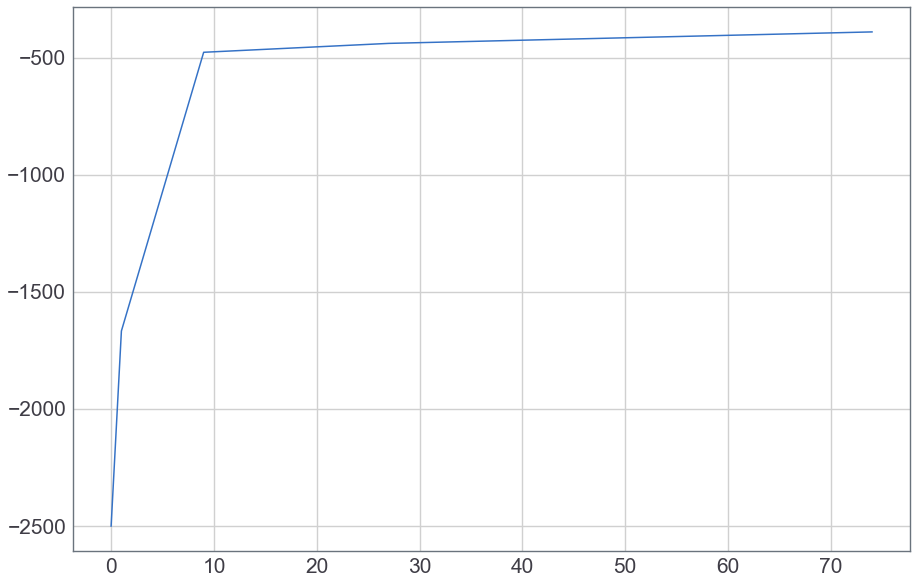

In [18]:
searcher.plot_search()

# Sample Model

In [19]:
run_env(env, lambda x: get_action(model, x, probabilistic=True), 5, render=True)

(-457.0, 0)